In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [11]:
#load the dataset and perform a quick overview
#csv but it uses tabs lmaooooo
data = pd.read_csv("marketing_campaign.csv", sep = "\t")

print (data.head())
print("Shape: ", data.shape)
print("NAs: \n", data.isnull().sum())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

In [12]:
#note, there are some nulls present
#knn needs to use cols that are "related" to income, but since its only 24 we can probably get away with just median

median_income = data["Income"].median()
data["Income"] = data["Income"].fillna(median_income)

print("NAs: \n", data.isnull().sum())

NAs: 
 ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64


In [ ]:
#clean up the data more

#we dont need id, we need to convert date, ad create customer tenure in days, we can also just drop orginal data col after
data = data.drop(columns=["ID"])
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], dayfirst = True)
data['Customer_Tenure'] = (pd.to_datetime("today") - data['Dt_Customer']).dt.days
data = data.drop(columns=["Dt_Customer"])

In [14]:
#feature engineering 

#group similar spendings
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                 'MntSweetProducts', 'MntGoldProds']

data['Total_Spending'] = data[spending_cols].sum(axis=1)

#total campaigns accepted
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
data['Total_Campaigns_Accepted'] = data[campaign_cols].sum(axis=1)

data = data.drop(columns=spending_cols + campaign_cols)

In [16]:
#one hot encode categorical vars

data = pd.get_dummies(data, columns = ["Education", "Marital_Status"], drop_first = True)

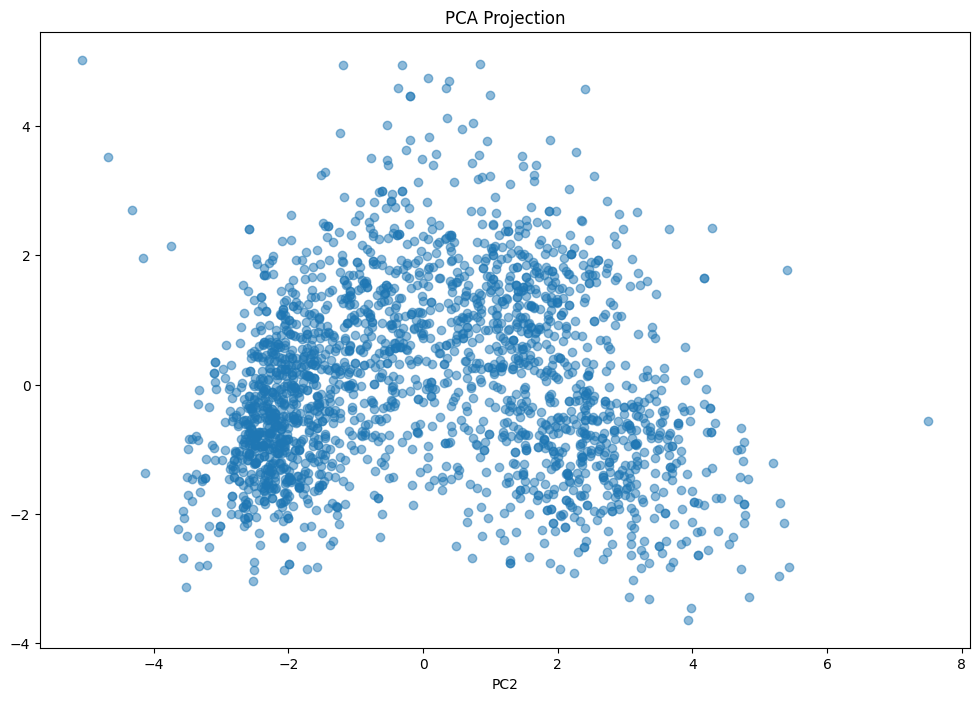

In [19]:
#standardize with standard Scaler
scaler = StandardScaler()
scaled = scaler.fit_transform(data)

#reduce dimensionality with PCA (2 cols)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled)

plt.figure(figsize=(12,8))
plt.scatter(pca_data[:,0], pca_data[:,1],alpha=0.5)
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.xlabel("PC2")
plt.show()

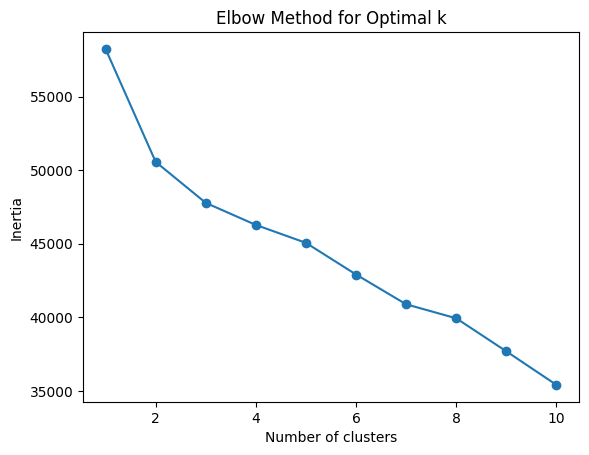

In [22]:
#figure out optimal cluster count with elbow method
#find spot where within-cluster sum of squares fall off
inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state =42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

k=4 seems sufficient, after k = 4, it sort of linearly goes down

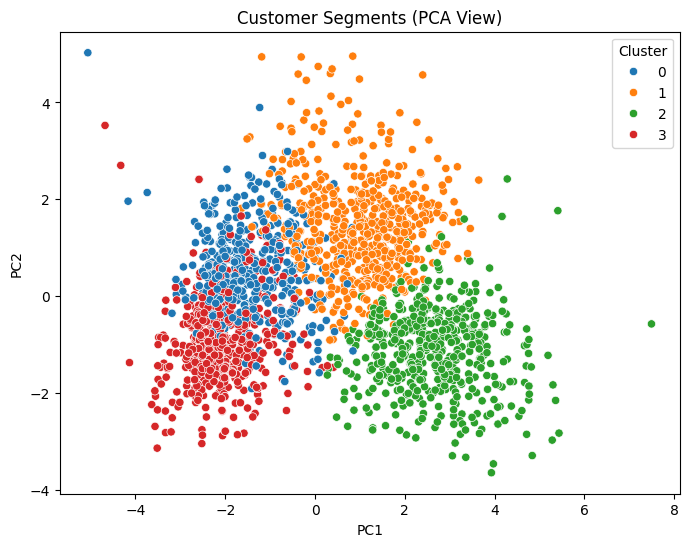

In [23]:
#apply k means clustering

kmeans = KMeans(n_clusters=4, random_state=42)

#make cluster col
data["Cluster"] = kmeans.fit_predict(scaled)


#visualize cluster in PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=data['Cluster'], palette='tab10')
plt.title("Customer Segments (PCA View)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

In [24]:
#profile said segments
profiles = data.groupby('Cluster').mean()
profiles["Num_Cust"] = data["Cluster"].value_counts().sort_index()
profiles

,Year_Birth,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,...,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Num_Cust
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1962.737769,43381.094912,0.688845,0.923679,51.786693,2.289628,2.281800,0.759295,3.630137,5.702544,...,0.248532,0.289628,0.001957,0.136986,0.315068,0.166341,0.338552,0.041096,0.000000,511
1,1964.712625,59516.826412,0.189369,0.956811,47.387043,3.707641,6.699336,3.350498,8.116279,5.674419,...,0.147841,0.255814,0.001661,0.127907,0.425249,0.149502,0.239203,0.053156,0.003322,602
2,1968.783835,77734.261278,0.037594,0.078947,49.669173,1.152256,4.842105,6.093985,8.193609,2.637218,...,0.157895,0.221805,0.000000,0.090226,0.345865,0.265038,0.257519,0.037594,0.000000,532
3,1978.178151,29683.309244,0.855462,0.073950,48.052101,2.005042,2.310924,0.531092,3.142857,7.018487,...,0.117647,0.110924,0.001681,0.062185,0.442017,0.275630,0.211765,0.006723,0.000000,595
